In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Solution method for the rolling-only bifurcation problem

In [2]:
L = 2.5

In [3]:
def on(z):
    kon0 = 10
    eta = 1e4
    d = .01
    return kon0*np.exp(-eta/2*((1 - np.cos(z) + d)**2 + (np.sin(z) - z)**2))

In [4]:
def off(z):
    d = .01
    return np.exp(np.sqrt((1 - np.cos(z) + d)**2 + (np.sin(z) - z)**2))

In [5]:
def fun(z, n):
    return -(on(z) - off(z)*n)/2

In [6]:
z_lin = np.linspace(np.pi/2, -np.pi/2, num=500)
sol = solve_ivp(fun, (np.pi/2, -np.pi/2), [0], t_eval=z_lin)

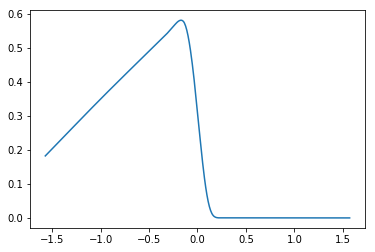

In [7]:
plt.plot(sol.t, sol.y.T)
plt.show()